In [1]:
#initializing Spark session
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import re
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]").appName("InsuranceClaimsPrediction").getOrCreate()
sc= spark.sparkContext
sc

<SparkContext master=local[1] appName=InsuranceClaimsPrediction>

In [2]:
#loading data
df = spark.read.format("csv").option("header", True).load(r"fraud_oracle.csv")

In [3]:
df.head()

Row(Month='Dec', WeekOfMonth='5', DayOfWeek='Wednesday', Make='Honda', AccidentArea='Urban', DayOfWeekClaimed='Tuesday', MonthClaimed='Jan', WeekOfMonthClaimed='1', Sex='Female', MaritalStatus='Single', Age='21', Fault='Policy Holder', PolicyType='Sport - Liability', VehicleCategory='Sport', VehiclePrice='more than 69000', FraudFound_P='0', PolicyNumber='1', RepNumber='12', Deductible='300', DriverRating='1', Days_Policy_Accident='more than 30', Days_Policy_Claim='more than 30', PastNumberOfClaims='none', AgeOfVehicle='3 years', AgeOfPolicyHolder='26 to 30', PoliceReportFiled='No', WitnessPresent='No', AgentType='External', NumberOfSuppliments='none', AddressChange_Claim='1 year', NumberOfCars='3 to 4', Year='1994', BasePolicy='Liability')

In [4]:
df.printSchema()

root
 |-- Month: string (nullable = true)
 |-- WeekOfMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- Make: string (nullable = true)
 |-- AccidentArea: string (nullable = true)
 |-- DayOfWeekClaimed: string (nullable = true)
 |-- MonthClaimed: string (nullable = true)
 |-- WeekOfMonthClaimed: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Fault: string (nullable = true)
 |-- PolicyType: string (nullable = true)
 |-- VehicleCategory: string (nullable = true)
 |-- VehiclePrice: string (nullable = true)
 |-- FraudFound_P: string (nullable = true)
 |-- PolicyNumber: string (nullable = true)
 |-- RepNumber: string (nullable = true)
 |-- Deductible: string (nullable = true)
 |-- DriverRating: string (nullable = true)
 |-- Days_Policy_Accident: string (nullable = true)
 |-- Days_Policy_Claim: string (nullable = true)
 |-- PastNumberOfClaims: string (nullable = true)
 

Lets findout the unique values in each column of the dataframe

In [5]:
# Iterating over DataFrame columns
for column in df.columns:
    print(column, ":\n")
    
    # Getting unique values for the column
    unique_values = df.select(column).distinct().rdd.flatMap(lambda x: x).collect()
    
    # Print unique values
    for value in unique_values:
        print(value)
    
    print('\n')

Month :

Oct
Sep
Dec
Aug
May
Jun
Feb
Nov
Mar
Jan
Apr
Jul


WeekOfMonth :

3
5
1
4
2


DayOfWeek :

Wednesday
Tuesday
Friday
Thursday
Saturday
Monday
Sunday


Make :

Lexus
Jaguar
Saturn
Nisson
Porche
Chevrolet
Saab
Honda
Pontiac
Mercury
BMW
Accura
Ferrari
VW
Mecedes
Toyota
Dodge
Mazda
Ford


AccidentArea :

Urban
Rural


DayOfWeekClaimed :

Wednesday
Tuesday
0
Friday
Thursday
Saturday
Monday
Sunday


MonthClaimed :

Oct
Sep
Dec
0
Aug
May
Jun
Feb
Nov
Mar
Jan
Apr
Jul


WeekOfMonthClaimed :

3
5
1
4
2


Sex :

Female
Male


MaritalStatus :

Married
Widow
Divorced
Single


Age :

51
54
29
69
42
73
64
30
34
59
28
22
52
35
16
0
71
47
43
31
18
70
27
61
75
17
26
46
78
77
60
68
19
41
23
55
38
40
25
44
53
58
33
48
67
79
24
32
20
56
36
37
49
63
65
39
62
21
66
72
74
76
80
50
45
57


Fault :

Policy Holder
Third Party


PolicyType :

Sedan - Liability
Utility - Collision
Utility - All Perils
Sedan - Collision
Sport - All Perils
Sport - Liability
Utility - Liability
Sedan - All Perils
Sport - Collis

By performing this we can quickly get an overview of the data present in each column of the DataFrame, which can be useful for data exploration.

In [6]:
# Getting unique values for the 'PolicyNumber' column
unique_policy_numbers = df.select("PolicyNumber").distinct().rdd.flatMap(lambda x: x).collect()

# Printing unique values
print(unique_policy_numbers)

['296', '467', '675', '691', '829', '1090', '1159', '1436', '1512', '1572', '2069', '2088', '2136', '2162', '2294', '2904', '3210', '3414', '3606', '3959', '4032', '4821', '4937', '5325', '6194', '6240', '6613', '6731', '7252', '7273', '7711', '7762', '8304', '8433', '9009', '9030', '9583', '9586', '9993', '10096', '10351', '10436', '11078', '11332', '11563', '11722', '11888', '12394', '12529', '12847', '13192', '13442', '13610', '13772', '13865', '14157', '14204', '14369', '14838', '14887', '14899', '15269', '15271', '5645', '5925', '13282', '125', '451', '800', '853', '944', '1372', '1394', '1669', '2110', '2275', '2393', '2464', '2756', '3015', '3281', '3368', '3441', '3517', '3650', '3826', '3858', '4838', '4894', '4975', '5023', '5067', '5523', '5613', '5657', '6366', '6558', '6797', '7362', '7650', '7655', '7743', '7994', '8092', '8306', '8386', '8965', '9003', '9032', '9308', '9407', '9569', '9630', '9830', '10272', '10309', '10338', '10603', '11205', '11236', '11247', '11313', 

"PolicyNumber" column contains unique identifiers for most of the rows, it might not offer much predictive power and could be redundant for modeling purposes.

In [7]:
df = df.drop("PolicyNumber")

In [8]:
# Selecting the 'Age' and 'AgeOfPolicyHolder' columns and display the first 20 rows
df.select("Age", "AgeOfPolicyHolder").show(20)


+---+-----------------+
|Age|AgeOfPolicyHolder|
+---+-----------------+
| 21|         26 to 30|
| 34|         31 to 35|
| 47|         41 to 50|
| 65|         51 to 65|
| 27|         31 to 35|
| 20|         21 to 25|
| 36|         36 to 40|
|  0|         16 to 17|
| 30|         31 to 35|
| 42|         36 to 40|
| 71|          over 65|
| 52|         41 to 50|
| 28|         31 to 35|
|  0|         16 to 17|
| 61|         51 to 65|
| 38|         36 to 40|
| 41|         36 to 40|
| 28|         31 to 35|
| 32|         31 to 35|
| 30|         31 to 35|
+---+-----------------+
only showing top 20 rows



It might seem that dataset has no missing values but actually the missing values are replaced with non-logical value so I replace them in these variables:

Days_Policy_Accident
Days_Policy_Claim
PastNumberOfClaims
NumberOfSuppliments
contain none as null.

In [9]:
from pyspark.sql.functions import when

# Replace 0 values with NaN in multiple columns
columns_to_replace = ['Age', 'DayOfWeekClaimed', 'MonthClaimed']

for column in columns_to_replace:
    df = df.withColumn(column, when(col(column) == 0, None).otherwise(col(column)))


Age
DayOfWeekClaimed
MonthClaimed
contain 0 instead of null.

There are also some features which are strings but have numerical meanings.we used regex to convert these features to numerical type:

NumberOfCars
NumberOfSuppliments
AgeOfPolicyHolder
AgeOfVehicle
PastNumberOfClaims
Days_Policy_Claim
Days_Policy_Accident
VehiclePrice

In [10]:
from pyspark.sql.functions import when

# Columns to replace 'none' with '0'
columns_to_replace_none = ['Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'NumberOfSuppliments']

# Replace 'none' with '0' in specified columns
for column in columns_to_replace_none:
    df = df.withColumn(column, when(col(column) == 'none', '0').otherwise(col(column)))

# Replace 'new' with '0' in 'AgeOfVehicle' and 'AddressChange_Claim' columns
df = df.withColumn('AgeOfVehicle', when(col('AgeOfVehicle') == 'new', '0').otherwise(col('AgeOfVehicle')))
df = df.withColumn('AddressChange_Claim', when(col('AddressChange_Claim') == 'new', '0').otherwise(col('AddressChange_Claim')))


In [11]:
from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import IntegerType

# Define the regex pattern
pattern = r'(\d+)'

# Columns to apply regex pattern
columns = ['NumberOfCars', 'NumberOfSuppliments', 'AgeOfPolicyHolder', 'AgeOfVehicle',
           'PastNumberOfClaims', 'Days_Policy_Claim', 'Days_Policy_Accident', 'VehiclePrice']

# Apply regex pattern to extract the first number from each value
for column in columns:
    df = df.withColumn(column, regexp_extract(df[column], pattern, 1).cast(IntegerType()))


In [12]:
from collections import Counter

# Get data types of all columns
column_types = [str(dtype) for name, dtype in df.dtypes]

# Count the occurrences of each data type
type_counts = Counter(column_types)

# Print the counts of unique data types
for data_type, count in type_counts.items():
    print(f"{data_type}: {count}")

string: 24
int: 8


Data Visualization

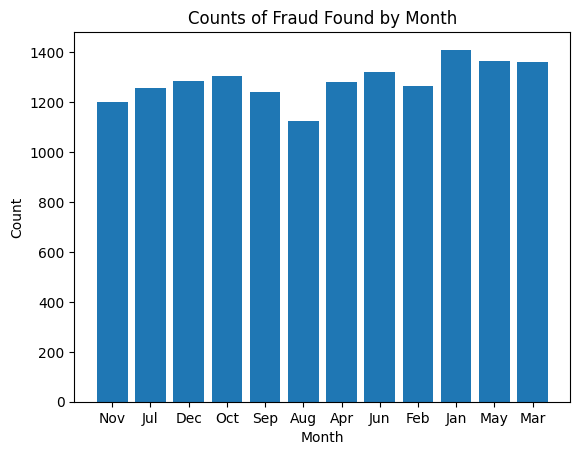

In [13]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Defining the order of months
months_list = ['Nov', 'Jul', 'Dec', 'Oct', 'Sep', 'Aug', 'Apr', 'Jun', 'Feb', 'Jan', 'May', 'Mar']

# Grouping by 'Month' and count occurrences of 'FraudFound_P'
counts_per_month = df.groupby('Month').count().orderBy(col('Month'))

# Extracting counts and months from the DataFrame
counts = [row['count'] for row in counts_per_month.collect()]
months = [row['Month'] for row in counts_per_month.collect()]

# Reordering counts according to months_list
ordered_counts = [counts[months.index(month)] for month in months_list]

# Plotting the bar chart
plt.bar(months_list, ordered_counts)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Counts of Fraud Found by Month')
plt.show()


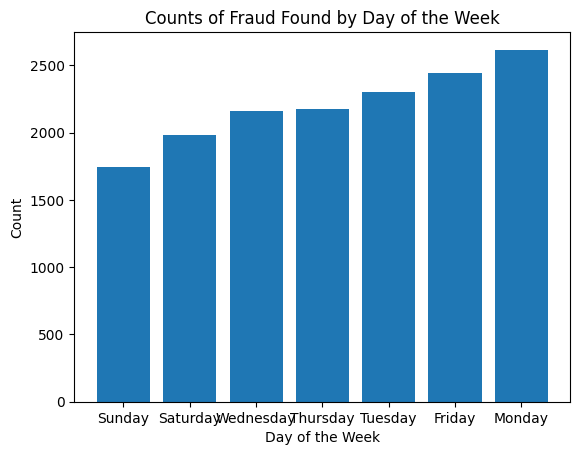

In [14]:
# Defining the order of days
days_list = ['Sunday', 'Saturday', 'Wednesday', 'Thursday', 'Tuesday', 'Friday', 'Monday']

# Grouping by 'DayOfWeek' and count occurrences of 'FraudFound_P'
counts_per_day = df.groupby('DayOfWeek').count().orderBy(col('DayOfWeek'))

# Extract ingcounts and days from the DataFrame
counts = [row['count'] for row in counts_per_day.collect()]
days = [row['DayOfWeek'] for row in counts_per_day.collect()]

# Reordeingr counts according to days_list
ordered_counts = [counts[days.index(day)] for day in days_list]

# Plotting the bar chart
plt.bar(days_list, ordered_counts)
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Counts of Fraud Found by Day of the Week')
plt.show()

In [15]:
# Grouping by 'Make' and count occurrences of 'FraudFound_P'
counts_per_make = df.groupby('Make').count().orderBy('count')

# Extracting the index (Make names)
make_names = [row['Make'] for row in counts_per_make.collect()]

# Converting to pandas DataFrame to access the index
make_names_df = spark.createDataFrame([(make,) for make in make_names], ['Make'])

# Converting to pandas DataFrame for easy indexing
make_names_pd = make_names_df.toPandas()

# Getting the index
index = make_names_pd['Make'].tolist()

print(index)


['Lexus', 'Ferrari', 'Mecedes', 'Porche', 'Jaguar', 'BMW', 'Nisson', 'Saturn', 'Mercury', 'Saab', 'Dodge', 'VW', 'Ford', 'Accura', 'Chevrolet', 'Mazda', 'Honda', 'Toyota', 'Pontiac']


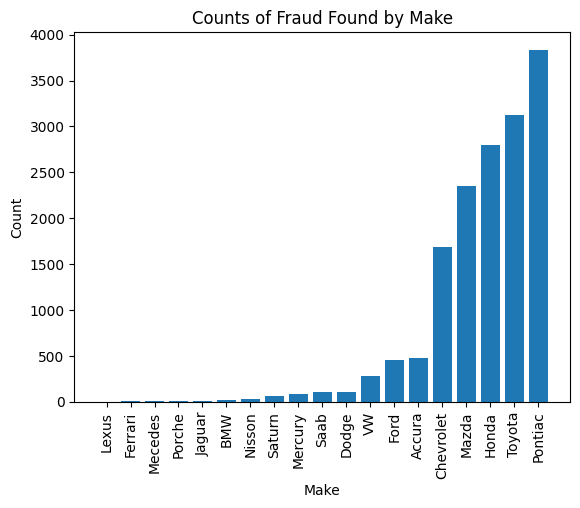

In [16]:
# Defining the list of makes
make_list = ['Lexus', 'Ferrari', 'Porche', 'Jaguar', 'Mecedes', 'BMW', 'Nisson',
             'Saturn', 'Dodge', 'Mercury', 'Saab', 'VW', 'Ford', 'Accura',
             'Chevrolet', 'Mazda', 'Honda', 'Toyota', 'Pontiac']

# Grouping by 'Make' and count occurrences of 'FraudFound_P'
counts_per_make = df.groupby('Make').count()

# Converting to Pandas DataFrame for sorting and plotting
counts_per_make_pd = counts_per_make.toPandas()

# Sorting the DataFrame by counts
counts_per_make_pd_sorted = counts_per_make_pd.sort_values(by='count')

# Plotingthe bar chart
plt.bar(counts_per_make_pd_sorted['Make'], counts_per_make_pd_sorted['count'])
plt.xlabel('Make')
plt.ylabel('Count')
plt.title('Counts of Fraud Found by Make')
plt.xticks(rotation='vertical')
plt.show()

Insights:
By analyzing above charts we noticed that 'Pontiac' make vehicles generate more accidents, we need to restrict our losses by incresing the premiums for that vehicles

In [17]:
# Grouping by 'Make' and count occurrences of 'FraudFound_P'
counts_per_make = df.groupby('Make').count()

# Sorting the DataFrame by counts in ascending order
counts_per_make_sorted = counts_per_make.orderBy(col('count'))

# Extract the counts and index
counts = [row['count'] for row in counts_per_make_sorted.collect()]
make_names = [row['Make'] for row in counts_per_make_sorted.collect()]

# Print the sorted counts
print(counts)

[1, 2, 4, 5, 6, 15, 30, 58, 83, 108, 109, 283, 450, 472, 1681, 2354, 2801, 3121, 3837]


The significance of this code is to analyze the distribution of fraud cases among different car makes. By sorting the counts of occurrences, it provides insights into which car makes are associated with fewer fraud cases compared to others. This information can be valuable for further analysis or decision-making processes related to fraud detection and prevention in the insurance domain.

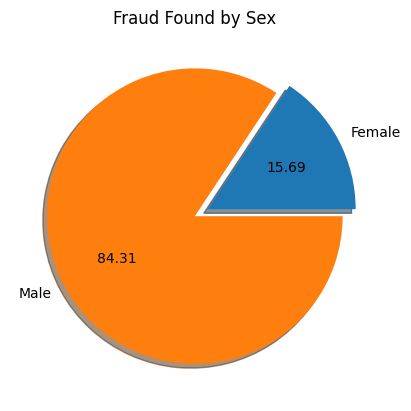

In [18]:
# Group by 'Sex' and count occurrences of 'FraudFound_P'
counts_per_sex = df.groupby('Sex').count()

# Convert to Pandas DataFrame for plotting
counts_per_sex_pd = counts_per_sex.toPandas()

# Sort the DataFrame by counts
counts_per_sex_pd_sorted = counts_per_sex_pd.sort_values(by='count')

# Plot the pie chart
plt.pie(counts_per_sex_pd_sorted['count'], labels=counts_per_sex_pd_sorted['Sex'], explode=[0.1, 0], shadow=True, autopct='%.2f')
plt.title('Fraud Found by Sex')
plt.show()

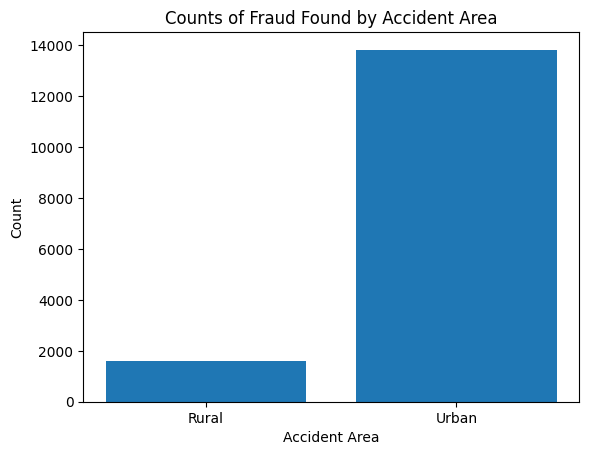

In [19]:
# Group by 'AccidentArea' and count occurrences of 'FraudFound_P'
counts_per_area = df.groupby('AccidentArea').count()

# Convert to Pandas DataFrame for sorting and plotting
counts_per_area_pd = counts_per_area.toPandas()

# Sort the DataFrame by counts
counts_per_area_pd_sorted = counts_per_area_pd.sort_values(by='count')

# Plot the bar chart
plt.bar(counts_per_area_pd_sorted['AccidentArea'], counts_per_area_pd_sorted['count'])
plt.xlabel('Accident Area')
plt.ylabel('Count')
plt.title('Counts of Fraud Found by Accident Area')
plt.show()

In [20]:
df.show()

+-----+-----------+---------+---------+------------+----------------+------------+------------------+------+-------------+----+-------------+--------------------+---------------+------------+------------+---------+----------+------------+--------------------+-----------------+------------------+------------+-----------------+-----------------+--------------+---------+-------------------+-------------------+------------+----+----------+
|Month|WeekOfMonth|DayOfWeek|     Make|AccidentArea|DayOfWeekClaimed|MonthClaimed|WeekOfMonthClaimed|   Sex|MaritalStatus| Age|        Fault|          PolicyType|VehicleCategory|VehiclePrice|FraudFound_P|RepNumber|Deductible|DriverRating|Days_Policy_Accident|Days_Policy_Claim|PastNumberOfClaims|AgeOfVehicle|AgeOfPolicyHolder|PoliceReportFiled|WitnessPresent|AgentType|NumberOfSuppliments|AddressChange_Claim|NumberOfCars|Year|BasePolicy|
+-----+-----------+---------+---------+------------+----------------+------------+------------------+------+------------

In [21]:
# Droping rows with NULL values
df = df.dropna()

# Displaying the first few rows of the DataFrame
df.show()


+-----+-----------+---------+---------+------------+----------------+------------+------------------+------+-------------+---+-------------+--------------------+---------------+------------+------------+---------+----------+------------+--------------------+-----------------+------------------+------------+-----------------+-----------------+--------------+---------+-------------------+-------------------+------------+----+----------+
|Month|WeekOfMonth|DayOfWeek|     Make|AccidentArea|DayOfWeekClaimed|MonthClaimed|WeekOfMonthClaimed|   Sex|MaritalStatus|Age|        Fault|          PolicyType|VehicleCategory|VehiclePrice|FraudFound_P|RepNumber|Deductible|DriverRating|Days_Policy_Accident|Days_Policy_Claim|PastNumberOfClaims|AgeOfVehicle|AgeOfPolicyHolder|PoliceReportFiled|WitnessPresent|AgentType|NumberOfSuppliments|AddressChange_Claim|NumberOfCars|Year|BasePolicy|
+-----+-----------+---------+---------+------------+----------------+------------+------------------+------+-------------+

In [22]:
# Get the data types of columns
column_types = df.dtypes

numerical_columns = [column[0] for column in column_types if column[1] == 'int']

# Print the list of numerical variables
print(numerical_columns)


['VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'NumberOfCars']


In [23]:

column_types = df.dtypes

# Filter for columns with string (object) data type
categorical_columns = [column[0] for column in column_types if column[1] == 'string']

# Print the list of categorical variables
print(categorical_columns)


['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory', 'FraudFound_P', 'RepNumber', 'Deductible', 'DriverRating', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'AddressChange_Claim', 'Year', 'BasePolicy']


In [24]:
# Print the schema of the DataFrame
df.printSchema()

# Display the number of rows in the DataFrame
print("Number of rows: ", df.count())

# Displaying summary statistics for numerical columns
df.describe().show()

# Displaying the first few rows of the DataFrame
df.show(5)


root
 |-- Month: string (nullable = true)
 |-- WeekOfMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- Make: string (nullable = true)
 |-- AccidentArea: string (nullable = true)
 |-- DayOfWeekClaimed: string (nullable = true)
 |-- MonthClaimed: string (nullable = true)
 |-- WeekOfMonthClaimed: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Fault: string (nullable = true)
 |-- PolicyType: string (nullable = true)
 |-- VehicleCategory: string (nullable = true)
 |-- VehiclePrice: integer (nullable = true)
 |-- FraudFound_P: string (nullable = true)
 |-- RepNumber: string (nullable = true)
 |-- Deductible: string (nullable = true)
 |-- DriverRating: string (nullable = true)
 |-- Days_Policy_Accident: integer (nullable = true)
 |-- Days_Policy_Claim: integer (nullable = true)
 |-- PastNumberOfClaims: integer (nullable = true)
 |-- AgeOfVehicle: integer (nullable = tr

In [25]:
# Get the unique values of the "NumberOfCars" column
unique_values = df.select('NumberOfCars').distinct().rdd.flatMap(lambda x: x).collect()

# Print the unique values
print(unique_values)


[1, 3, 5, 8, 2]


There are also claims involving multiple cars, such as 2, 3, 5, and 8, which might indicate accidents or incidents involving more than one vehicle

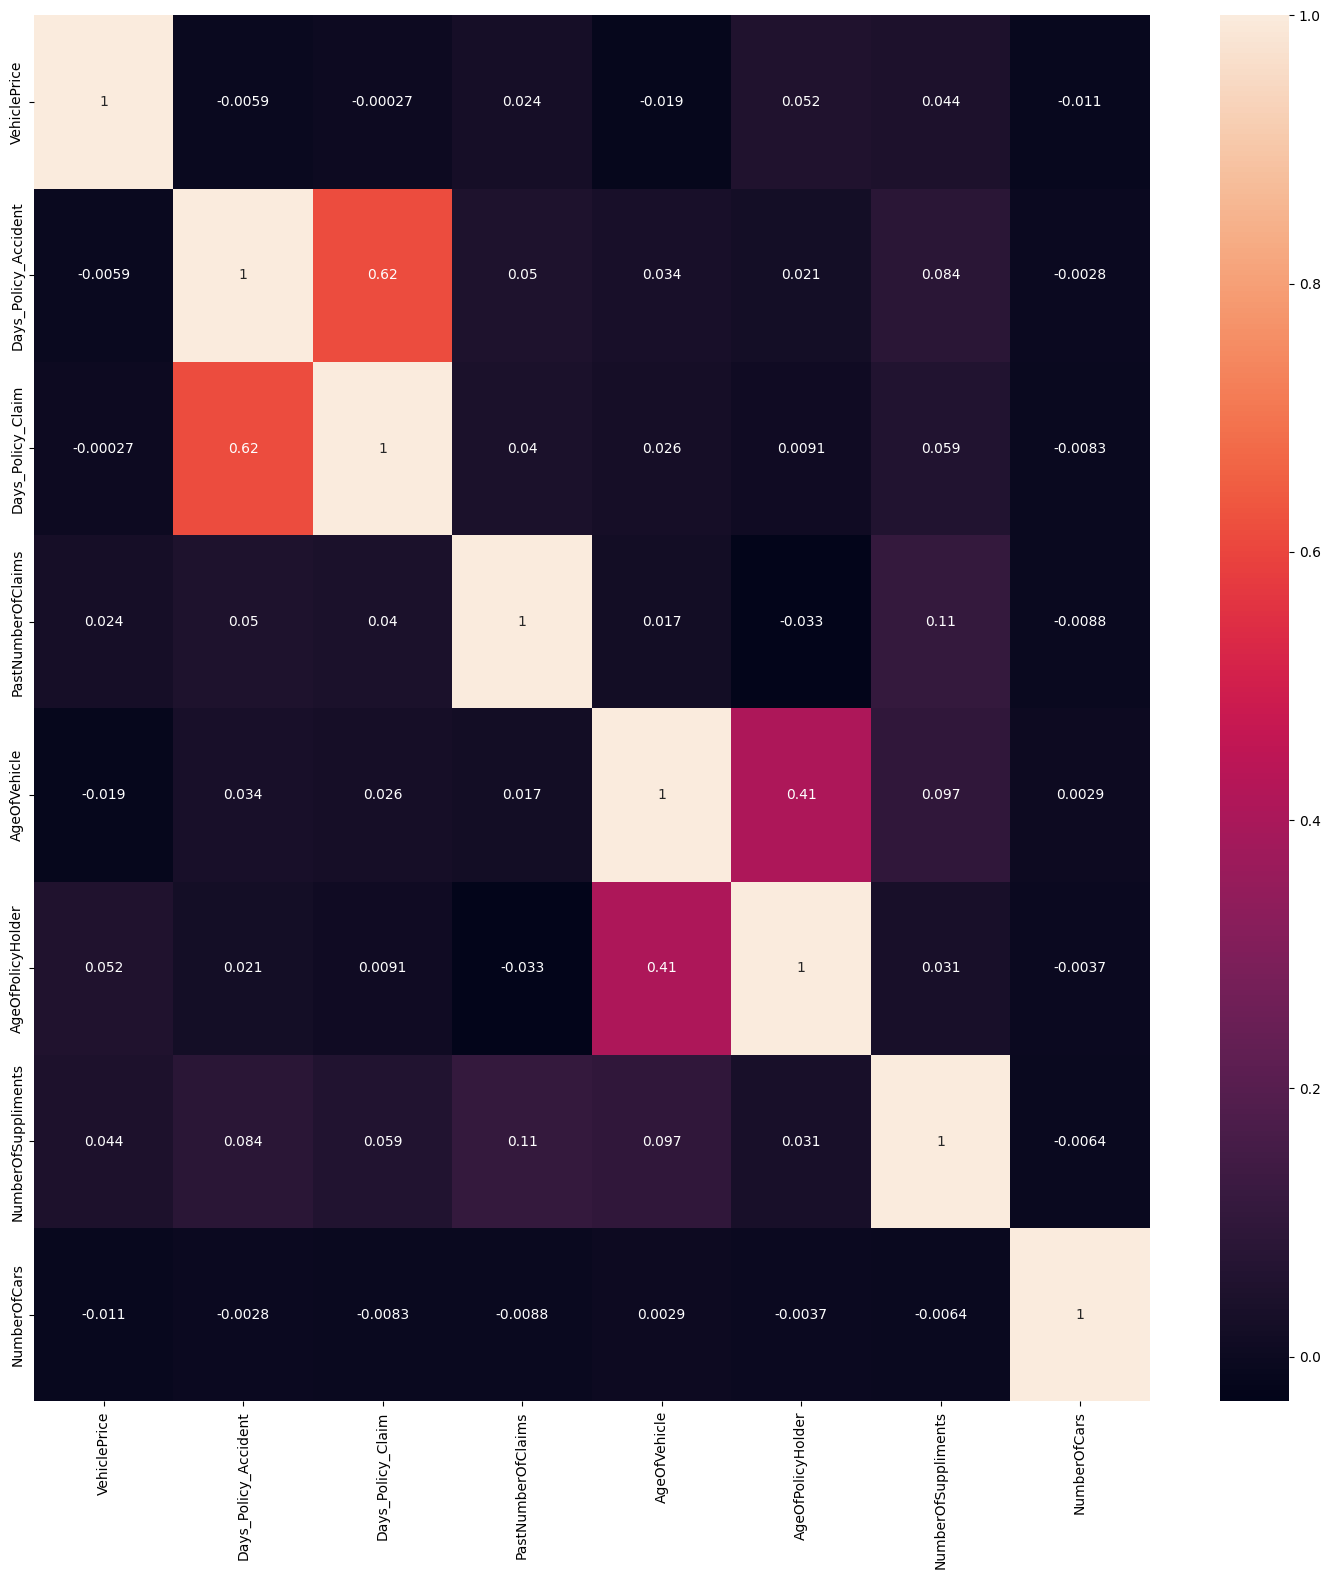

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# Select only numeric columns for correlation calculation
numeric_cols = [col for col, dtype in df.dtypes if dtype in ['int', 'float']]

# Compute the correlation matrix
correlation_matrix = df.select(numeric_cols).toPandas().corr()

# Plot the heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [27]:
# Get the column names of the DataFrame
column_names = df.columns

# Print the column names
print(column_names)


['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex', 'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'FraudFound_P', 'RepNumber', 'Deductible', 'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year', 'BasePolicy']


 By removing the following columns,we aim to simplify the dataset and focus on the relationships between the remaining numeric variables. Additionally,  the correlation matrix heatmap visualization provide insights into the pairwise correlations among these retained numeric variables.

In [28]:
# List of columns to drop
columns_to_drop = ['BasePolicy', 'Fault', 'PolicyType', 'PastNumberOfClaims', 'Year', 'NumberOfSuppliments',
                   'AgentType', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled',
                   'WitnessPresent', 'VehicleCategory', 'Make', 'AccidentArea']

# Droping the columns from the DataFrame
df = df.drop(*columns_to_drop)


In [29]:
# Displaying the first few rows of the DataFrame
df.show(1000)


+-----+-----------+---------+----------------+------------+------------------+------+-------------+---+------------+------------+---------+----------+------------+--------------------+-----------------+-------------------+------------+
|Month|WeekOfMonth|DayOfWeek|DayOfWeekClaimed|MonthClaimed|WeekOfMonthClaimed|   Sex|MaritalStatus|Age|VehiclePrice|FraudFound_P|RepNumber|Deductible|DriverRating|Days_Policy_Accident|Days_Policy_Claim|AddressChange_Claim|NumberOfCars|
+-----+-----------+---------+----------------+------------+------------------+------+-------------+---+------------+------------+---------+----------+------------+--------------------+-----------------+-------------------+------------+
|  Dec|          5|Wednesday|         Tuesday|         Jan|                 1|Female|       Single| 21|       69000|           0|       12|       300|           1|                  30|               30|             1 year|           3|
|  Jan|          3|Wednesday|          Monday|         J

In [30]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

# Defining StringIndexer for the target variable
label_indexer = StringIndexer(inputCol="FraudFound_P", outputCol="label", handleInvalid="skip")

# Define categorical columns
categorical_cols = ['Month', 'WeekOfMonth', 'DayOfWeek', 'DayOfWeekClaimed', 
                    'MonthClaimed', 'WeekOfMonthClaimed', 'Sex', 'MaritalStatus']

# Defining numeric columns
numeric_cols = [col_name for col_name, col_type in df.dtypes if col_type in ['int', 'bigint', 'double']]

# StringIndexer for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_cols]

# OneHotEncoder for indexed categorical columns
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in categorical_cols]

# Assembling features
assembler = VectorAssembler(inputCols=numeric_cols + [col+"_encoded" for col in categorical_cols], outputCol="features")

# Creating a pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, label_indexer])

# Fitting pipeline to DataFrame
pipeline_model = pipeline.fit(df)

# Transforming DataFrame
transformed_df = pipeline_model.transform(df)

# Selecting features and target variable
transformed_df = transformed_df.select("features", "label")  # Using "label" as the target variable

# Splitting the data into training and testing sets
train_df, test_df = transformed_df.randomSplit([0.8, 0.2], seed=20)


**Random Forest Classifier**

In [37]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=200, maxDepth=10, featureSubsetStrategy="auto", seed=1234)

# Train the model
model_rf = rf.fit(train_df)

# Make predictions on the training data
train_predictions_rf = model_rf.transform(train_df)



In [38]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
train_accuracy_rf = evaluator.evaluate(train_predictions_rf)

print("Random Forest Classifier Training Accuracy:", train_accuracy_rf)

# Evaluate F1 score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
train_f1_score_rf = evaluator_f1.evaluate(train_predictions_rf)

# Evaluate recall
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
train_recall_rf = evaluator_recall.evaluate(train_predictions_rf)

# Evaluate precision
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
train_precision_rf = evaluator_precision.evaluate(train_predictions_rf)

print("Random Forest Classifier Training F1 Score:", train_f1_score_rf)
print("Random Forest Classifier Training Recall:", train_recall_rf)
print("Random Forest Classifier Training Precision:", train_precision_rf)


Random Forest Classifier Training Accuracy: 0.9420673673756518
Random Forest Classifier Training F1 Score: 0.914129856317955
Random Forest Classifier Training Recall: 0.9420673673756518
Random Forest Classifier Training Precision: 0.9454241129130281


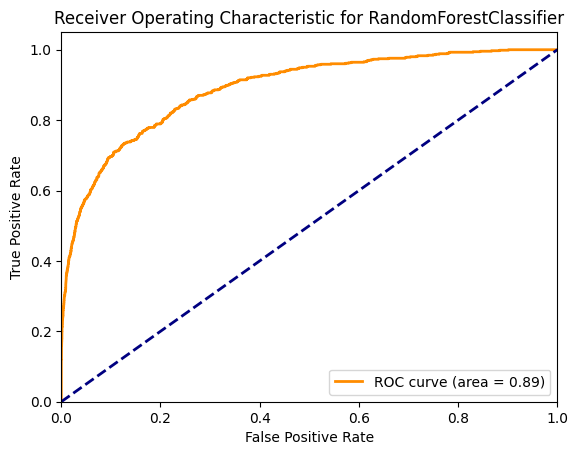

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Convert predictions to pandas DataFrame
train_predictions_rf_pd = train_predictions_rf.select(['label', 'probability']).toPandas()

# Extract probabilities of positive class
probs = train_predictions_rf_pd['probability'].apply(lambda x: x[1])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(train_predictions_rf_pd['label'], probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()


In [51]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Making predictions on the test data
test_predictions_rf = model_rf.transform(test_df)


test_accuracy_rf = evaluator_accuracy_rf.evaluate(test_predictions_rf)

# Evaluating F1 score on test data
test_f1_score_rf = evaluator_f1_rf.evaluate(test_predictions_rf)

# Evaluating recall on test data
test_recall_rf = evaluator_recall_rf.evaluate(test_predictions_rf)

# Evaluating precision on test data
test_precision_rf = evaluator_precision_rf.evaluate(test_predictions_rf)

print("Random Forest Classifier Test Accuracy:", test_accuracy_rf)
print("Random Forest Classifier Test F1 Score:", test_f1_score_rf)
print("Random Forest Classifier Test Recall:", test_recall_rf)
print("Random Forest Classifier Test Precision:", test_precision_rf)


Random Forest Classifier Test Accuracy: 0.9370235333112363
Random Forest Classifier Test F1 Score: 0.9065590447196663
Random Forest Classifier Test Recall: 0.9370235333112363
Random Forest Classifier Test Precision: 0.8780131019790737


**Logistic Regression**

In [39]:
from pyspark.ml.classification import LogisticRegression

# Defining the LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Training the model
lr_model = lr.fit(train_df)

# Making predictions on the training data
train_predictions_lr = lr_model.transform(train_df)




In [40]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluating accuracy
evaluator_accuracy_lr = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
train_accuracy_lr = evaluator_accuracy_lr.evaluate(train_predictions_lr)

# Evaluating F1 score
evaluator_f1_lr = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
train_f1_score_lr = evaluator_f1_lr.evaluate(train_predictions_lr)

# Evaluating recall
evaluator_recall_lr = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
train_recall_lr = evaluator_recall_lr.evaluate(train_predictions_lr)

# Evaluating precision
evaluator_precision_lr = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
train_precision_lr = evaluator_precision_lr.evaluate(train_predictions_lr)

print("Logistic Regression Classifier Training Accuracy:", train_accuracy_lr)
print("Logistic Regression Classifier Training F1 Score:", train_f1_score_lr)
print("Logistic Regression Classifier Training Recall:", train_recall_lr)
print("Logistic Regression Classifier Training Precision:", train_precision_lr)


Logistic Regression Classifier Training Accuracy: 0.9419018455681536
Logistic Regression Classifier Training F1 Score: 0.9137218636559117
Logistic Regression Classifier Training Recall: 0.9419018455681536
Logistic Regression Classifier Training Precision: 0.8871790866846938


In [52]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Make predictions on the test data
test_predictions_lr = lr_model.transform(test_df)



# Evaluate accuracy on test data
test_accuracy_lr = evaluator_accuracy_lr.evaluate(test_predictions_lr)

# Evaluate F1 score on test data
test_f1_score_lr = evaluator_f1_lr.evaluate(test_predictions_lr)

# Evaluate recall on test data
test_recall_lr = evaluator_recall_lr.evaluate(test_predictions_lr)

# Evaluate precision on test data
test_precision_lr = evaluator_precision_lr.evaluate(test_predictions_lr)

print("Logistic Regression Classifier Test Accuracy:", test_accuracy_lr)
print("Logistic Regression Classifier Test F1 Score:", test_f1_score_lr)
print("Logistic Regression Classifier Test Recall:", test_recall_lr)
print("Logistic Regression Classifier Test Precision:", test_precision_lr)



Logistic Regression Classifier Test Accuracy: 0.9370235333112363
Logistic Regression Classifier Test F1 Score: 0.9065590447196663
Logistic Regression Classifier Test Recall: 0.9370235333112363
Logistic Regression Classifier Test Precision: 0.8780131019790737


In [41]:
from pyspark.ml.classification import LinearSVC

# Define the LinearSVC
svm = LinearSVC(featuresCol="features", labelCol="label")

# Train the model
svm_model = svm.fit(train_df)

# Make predictions on the training data
train_predictions_svm = svm_model.transform(train_df)



In [42]:


# Evaluate accuracy
evaluator_accuracy_svm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
train_accuracy_svm = evaluator_accuracy_svm.evaluate(train_predictions_svm)

# Evaluate F1 score
evaluator_f1_svm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
train_f1_score_svm = evaluator_f1_svm.evaluate(train_predictions_svm)

# Evaluate recall
evaluator_recall_svm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
train_recall_svm = evaluator_recall_svm.evaluate(train_predictions_svm)

# Evaluate precision
evaluator_precision_svm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
train_precision_svm = evaluator_precision_svm.evaluate(train_predictions_svm)

print("LinearSVC Classifier Training Accuracy:", train_accuracy_svm)
print("LinearSVC Classifier Training F1 Score:", train_f1_score_svm)
print("LinearSVC Classifier Training Recall:", train_recall_svm)
print("LinearSVC Classifier Training Precision:", train_precision_svm)


LinearSVC Classifier Training Accuracy: 0.9419018455681536
LinearSVC Classifier Training F1 Score: 0.9137218636559117
LinearSVC Classifier Training Recall: 0.9419018455681536
LinearSVC Classifier Training Precision: 0.8871790866846938


In [53]:
# Make predictions on the test data
test_predictions_svm = svm_model.transform(test_df)

# Evaluate accuracy on test data
test_accuracy_svm = evaluator_accuracy_svm.evaluate(test_predictions_svm)

# Evaluate F1 score on test data
test_f1_score_svm = evaluator_f1_svm.evaluate(test_predictions_svm)

# Evaluate recall on test data
test_recall_svm = evaluator_recall_svm.evaluate(test_predictions_svm)

# Evaluate precision on test data
test_precision_svm = evaluator_precision_svm.evaluate(test_predictions_svm)

print("LinearSVC Classifier Test Accuracy:", test_accuracy_svm)
print("LinearSVC Classifier Test F1 Score:", test_f1_score_svm)
print("LinearSVC Classifier Test Recall:", test_recall_svm)
print("LinearSVC Classifier Test Precision:", test_precision_svm)

LinearSVC Classifier Test Accuracy: 0.9370235333112363
LinearSVC Classifier Test F1 Score: 0.9065590447196663
LinearSVC Classifier Test Recall: 0.9370235333112363
LinearSVC Classifier Test Precision: 0.8780131019790737


Interpretation:       
The Random Forest Classifier has the highest accuracy and AUC ROC score on both the training and test sets, it can be considered the best model for this Dataset.

In [37]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import when

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Random Forest Classifier") \
    .getOrCreate()

# Sample input data for testing
input_data = [[10, 2, 5, 2, 11, 2, 1, 1]]

# Define the schema for input data
schema = StructType([
    StructField("Month", IntegerType(), True),
    StructField("WeekOfMonth", IntegerType(), True),
    StructField("DayOfWeek", IntegerType(), True),
    StructField("DayOfWeekClaimed", IntegerType(), True),
    StructField("MonthClaimed", IntegerType(), True),
    StructField("WeekOfMonthClaimed", IntegerType(), True),
    StructField("Sex", IntegerType(), True),
    StructField("MaritalStatus", IntegerType(), True)
])

# Create DataFrame from input data
input_df = spark.createDataFrame(input_data, schema)

# Add a label column
input_df = input_df.withColumn("label", input_df["Month"] + input_df["WeekOfMonth"])

# Assemble the feature vectors
feature_columns = input_df.columns[:-1]  # Exclude the label column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
input_df = assembler.transform(input_df)

# Define the RandomForestClassifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=200, maxDepth=10, featureSubsetStrategy="auto", seed=1234)

# Train the model
model_rf = rf.fit(input_df)

# Make predictions on the input data
predictions = model_rf.transform(input_df)

# Apply thresholding to predictions
threshold = 0.5
predictions = predictions.withColumn("prediction_Fraud", when(predictions["prediction"] > threshold, 1).otherwise(0))

# Show the binary predictions
predictions.select("prediction_Fraud").show()



+----------------+
|prediction_Fraud|
+----------------+
|               1|
+----------------+

